In [1]:
import tensorflow as tf
from tensorflow import keras
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import os
from keras.models import model_from_json
import json

Using TensorFlow backend.


In [2]:
df = pd.read_pickle('PN4_100sdown.pkl')

In [7]:
#TIME LAG
df_to_use = df

n_seconds = 1 #how many periods to lag
n_features= len(df_to_use.columns)-1 #how many features exist in the feature matrix (number of cols - target col)
time_lagged = series_to_supervised(df_to_use,n_in=0,n_out=n_seconds,dropnan=False) #lag function
time_lagged_reframed = delete_unwanted_cols(time_lagged) #delete unneccesary columns


#Make mass flux at t the last column
loc = time_lagged_reframed.columns.get_loc('m_dot(t)')

cols = time_lagged_reframed.columns.tolist()
cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
time_lagged_reframed = time_lagged_reframed[cols]

time_lagged_reframed

,Pic_CO2(t),ANEM_Y(t),ANEM_X(t),ANEM_Z(t),wd(t),ws(t),m_dot(t)
Corrected_DT,,,,,,,
2019-09-23 23:56:40,412.793091,0.142484,-0.789375,-0.136851,100.231839,1.116344,NaN
2019-09-23 23:58:20,412.700030,0.348316,-0.890475,-0.078872,111.363341,1.259322,NaN
2019-09-24 00:00:00,411.435105,0.538827,-0.778852,-0.049651,124.676329,1.101463,NaN
2019-09-24 00:01:40,412.611022,0.657877,-0.750211,-0.102658,131.248273,1.060958,NaN
2019-09-24 00:03:20,409.303550,1.063700,-1.051366,-0.134448,135.334109,1.486856,NaN
...,...,...,...,...,...,...,...
2019-10-03 13:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-03 13:21:40,428.947234,0.338540,0.341103,-0.258126,225.216093,0.482393,NaN
2019-10-03 13:23:20,437.987568,-0.573586,0.910787,0.260077,302.201464,1.288048,NaN


In [17]:
values = time_lagged_reframed.dropna().values #Convert to numpy for processing
min_max_scalar = preprocessing.MinMaxScaler() #setup scaling
values_scaled = min_max_scalar.fit_transform(values) #scale all values from 0 to 1

#Set train size. Because time is a factor, we do not choose randomly, but chronologically
percent_train = 0.7
train_size = int(len(values)*percent_train) 

train = values_scaled[:train_size,:]  #Get train/test arrays
test = values_scaled[train_size:,:]

X_train,y_train = train[:,:-1], train[:,-1] #Get feature/target arrays
X_test, y_test = test[:,:-1], test[:,-1]

orig_X_train_shape = X_train.shape
orig_X_test_shape = X_test.shape
orig_y_train_shape = y_train.shape
orig_y_test_shape = y_test.shape

X_train = X_train.reshape((X_train.shape[0], n_seconds, n_features)) 
X_test = X_test.reshape((X_test.shape[0], n_seconds, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5399, 1, 6) (5399,) (2315, 1, 6) (2315,)


In [42]:
#Gridsearch

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


from keras.wrappers.scikit_learn import KerasClassifier

def create_model():
    def rmse(y_true, y_pred):
        from keras import backend
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
    def r_square(y_true, y_pred):
        from keras import backend as K
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return (1 - SS_res/(SS_tot + K.epsilon()))
    model = Sequential()
    model.add(LSTM(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

    model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model,verbose=10)

batch_size = [5,10,20]
epochs = [1,3,5]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3,verbose=10)
grid_result = grid.fit(X_train, y_train,verbose=False)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] batch_size=5, epochs=1 ..........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. batch_size=5, epochs=1, score=0.004, total=   7.1s
[CV] batch_size=5, epochs=1 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] .............. batch_size=5, epochs=1, score=0.000, total=   7.0s
[CV] batch_size=5, epochs=1 ..........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s


[CV] .............. batch_size=5, epochs=1, score=0.000, total=   7.8s
[CV] batch_size=5, epochs=3 ..........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.0s remaining:    0.0s


[CV] .............. batch_size=5, epochs=3, score=0.004, total=  17.0s
[CV] batch_size=5, epochs=3 ..........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.9s remaining:    0.0s


[CV] .............. batch_size=5, epochs=3, score=0.000, total=  16.5s
[CV] batch_size=5, epochs=3 ..........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.4s remaining:    0.0s


[CV] .............. batch_size=5, epochs=3, score=0.000, total=  17.1s
[CV] batch_size=5, epochs=5 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV] .............. batch_size=5, epochs=5, score=0.004, total=  26.0s
[CV] batch_size=5, epochs=5 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.6min remaining:    0.0s


[CV] .............. batch_size=5, epochs=5, score=0.000, total=  26.3s
[CV] batch_size=5, epochs=5 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.1min remaining:    0.0s


[CV] .............. batch_size=5, epochs=5, score=0.000, total=  26.8s
[CV] batch_size=10, epochs=1 .........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.5min remaining:    0.0s


[CV] ............. batch_size=10, epochs=1, score=0.004, total=   5.5s
[CV] batch_size=10, epochs=1 .........................................
[CV] ............. batch_size=10, epochs=1, score=0.000, total=   5.1s
[CV] batch_size=10, epochs=1 .........................................
[CV] ............. batch_size=10, epochs=1, score=0.000, total=   5.3s
[CV] batch_size=10, epochs=3 .........................................
[CV] ............. batch_size=10, epochs=3, score=0.004, total=   9.7s
[CV] batch_size=10, epochs=3 .........................................
[CV] ............. batch_size=10, epochs=3, score=0.000, total=   9.6s
[CV] batch_size=10, epochs=3 .........................................
[CV] ............. batch_size=10, epochs=3, score=0.000, total=  10.3s
[CV] batch_size=10, epochs=5 .........................................
[CV] ............. batch_size=10, epochs=5, score=0.004, total=  14.6s
[CV] batch_size=10, epochs=5 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  5.1min finished


Best: 0.001481 using {'batch_size': 5, 'epochs': 1}
0.001481 (0.002095) with: {'batch_size': 5, 'epochs': 1}
0.001481 (0.002095) with: {'batch_size': 5, 'epochs': 3}
0.001481 (0.002095) with: {'batch_size': 5, 'epochs': 5}
0.001481 (0.002095) with: {'batch_size': 10, 'epochs': 1}
0.001481 (0.002095) with: {'batch_size': 10, 'epochs': 3}
0.001481 (0.002095) with: {'batch_size': 10, 'epochs': 5}
0.001481 (0.002095) with: {'batch_size': 20, 'epochs': 1}
0.001481 (0.002095) with: {'batch_size': 20, 'epochs': 3}
0.001481 (0.002095) with: {'batch_size': 20, 'epochs': 5}


In [9]:
# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

#Train Model
model = Sequential()
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))
opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

model.compile(loss='mse',optimizer=opt,metrics=["mean_squared_error", rmse, r_square])
history = model.fit(X_train,y_train,epochs=5,batch_size=20,validation_data=(X_test,y_test))

Train on 5399 samples, validate on 2315 samples
Epoch 1/5
5399/5399 [==============================] - 4s 653us/step - loss: 0.0828 - mean_squared_error: 0.0828 - rmse: 0.2447 - r_square: -1.2103 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - val_rmse: 0.2047 - val_r_square: -2291283.5000
Epoch 2/5
5399/5399 [==============================] - 2s 359us/step - loss: 0.0518 - mean_squared_error: 0.0518 - rmse: 0.1841 - r_square: -0.1983 - val_loss: 0.0481 - val_mean_squared_error: 0.0481 - val_rmse: 0.1790 - val_r_square: -1784163.0000
Epoch 3/5
5399/5399 [==============================] - 2s 377us/step - loss: 0.0439 - mean_squared_error: 0.0439 - rmse: 0.1699 - r_square: 4.6037e-05 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_rmse: 0.1501 - val_r_square: -1300812.2500
Epoch 4/5
5399/5399 [==============================] - 2s 386us/step - loss: 0.0387 - mean_squared_error: 0.0387 - rmse: 0.1530 - r_square: 0.0562 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - v

In [34]:
y_fit = model.predict(X_test) #fit to x_test

In [39]:
X_test_original_shape = X_test.reshape(orig_X_test_shape)
y_test_original_shape = y_test.reshape(orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1)
unscaled_test = pd.DataFrame(min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

y_fit_original_shape = y_fit.reshape(orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']

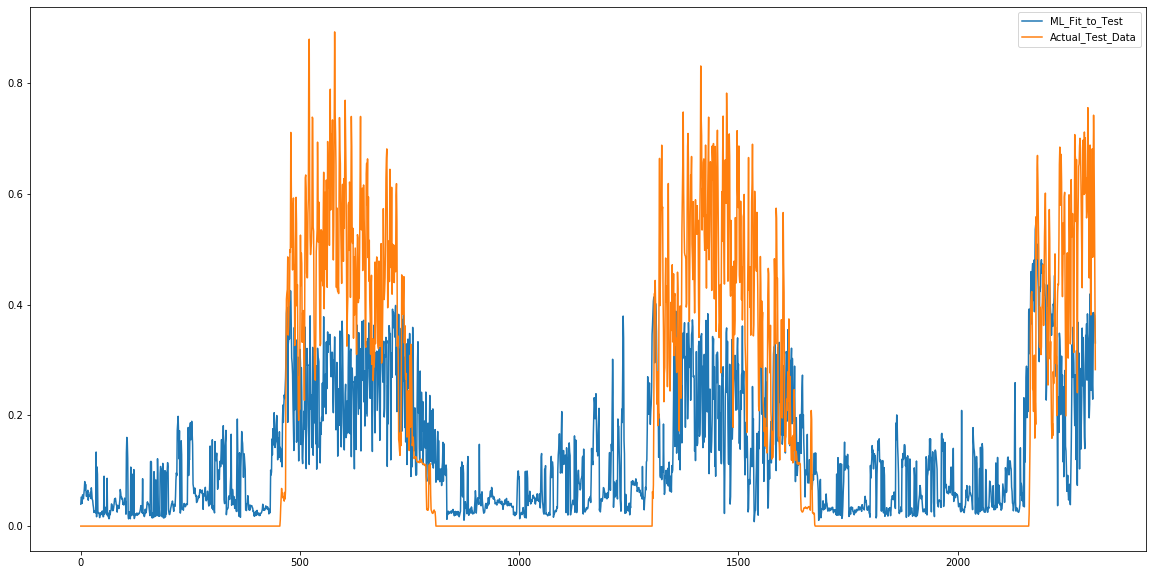

In [41]:
#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))

ax.plot(y_fit,label='ML_Fit_to_Test')
ax.plot(y_test,label='Actual_Test_Data')

# roll = 1

# ax.plot(comparison['fit'].rolling(roll).mean(),label='ML_Fit_to_Test')
# ax.plot(comparison['test'].rolling(roll).mean(),label='Actual_Test_Data')

ax.legend()